In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *

!pip install seaborn
import seaborn as sns

matplotlib.rc('image', cmap='Greys')

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#2) [Path('training'),Path('testing')]

## Introduction

This notebook is an exploration of gradient descent for simple learning problems. It is loosely based on the MNIST basics notebook in the [fastai](https://github.com/fastai/fastbook) course.

We'll begin by setting up a basic model as a baseline, then explore the applications of gradient descent to optimising a 1-layer model. For the baseline model we will assign a data point to the class with the closest mean, measured here by the 2-norm. For simplicity we'll focus initially only on digits $1,3,5$.

In [5]:
ones=(path/'training/1').ls().sorted()
threes=(path/'training/3').ls().sorted()
fives=(path/'training/5').ls().sorted()

In [6]:
def pull_images(paths):
    images=[tensor(Image.open(img)) for img in paths.ls().sorted()]
    return torch.stack(images)/255

In [7]:
ones=pull_images(path/'training/1')
threes=pull_images(path/'training/3')
fives=pull_images(path/'training/5')

In [8]:
def display_weight(weights, x=28, y=28, ax=None):
    weights= weights.view(x,y)
    sns.heatmap(weights, annot=False, ax=ax,  xticklabels=False, yticklabels=False)

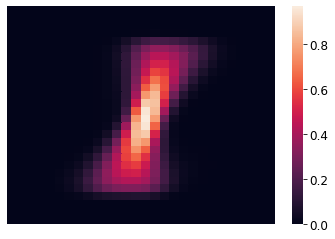

In [9]:
mean1 = ones.mean(0)
display_weight(mean1)

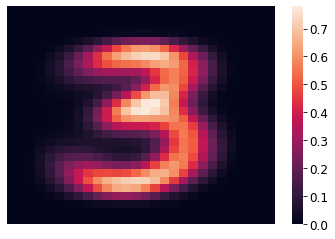

In [10]:
mean3 = threes.mean(0)
display_weight(mean3)

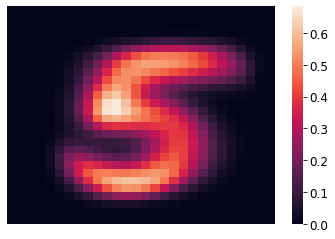

In [11]:
mean5 = fives.mean(0)
display_weight(mean5)

In [12]:
test_ones=pull_images(path/'testing/1')
test_threes=pull_images(path/'testing/3')
test_fives=pull_images(path/'testing/5')

In [13]:
def l2_distance(a,b): return ((a-b)**2).sum((-1,-2)).sqrt()

def compare(x,ys):
    distances=torch.stack(tuple(
        ys.map(lambda y: l2_distance(x, y))
    ))
    return torch.transpose(distances,0,1)

def preds(x,ys):
    return compare(x, ys).argmin(1)

In [14]:
weights= torch.stack([mean1,mean3,mean5]).reshape(3,28*28)

In [15]:
means=L([mean1,mean3,mean5])

In [16]:
pred_1=preds(test_ones, means).apply_(lambda x: x==0).float()
pred_3=preds(test_threes, means).apply_(lambda x: x==1).float()
pred_5=preds(test_fives, means).apply_(lambda x: x==2).float()

In [17]:
print(f'Ones accuracy: {pred_1.mean()}')
print(f'Threes accuracy: {pred_3.mean()}')
print(f'Fives accuracy: {pred_5.mean()}')
print(f'Overall accuracy {torch.cat((pred_1,pred_3,pred_5)).mean()}')

Ones accuracy: 0.9859030842781067
Threes accuracy: 0.8851485252380371
Fives accuracy: 0.7713004350662231
Overall accuracy 0.88936448097229


In [18]:
compare(test_fives, means).mean(0),compare(test_ones, means).mean(0)

(tensor([8.4132, 7.5366, 6.8510]), tensor([4.6192, 6.9743, 6.7614]))

In [19]:
most_similar=torch.stack(tuple(
        means.map(lambda y: l2_distance(test_threes, y))
    )).argmin(-1)

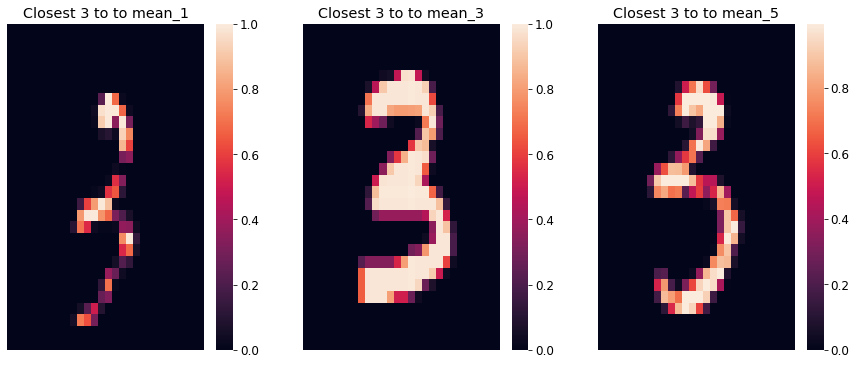

In [20]:
fig, ax =plt.subplots(1,3, figsize=(15,6))

digits=['1', '3', '5']

for i,axis in enumerate(ax):
    display_weight(test_threes[most_similar[i]], ax=axis)
    axis.set_title(f'Closest 3 to to mean_{digits[i]}')



An accuracy of 89% doesn't seem too bad for a first try. It also has the advantage of being very quick - there's no training required at all. That being said we would expect it to be signficicantly worse with more digits. In particular it may find similar looking digits like $4$ and $9$ to be harder to tell apart. It already struggles with the common bottom curve of 3 and 5.

## Aside on Differentiation

You're probably familiar with differentiation in some context. For those who haven't seen it in a while, or aren't totally comfortable with multivariate derivatives here is a quick refresher.

Given a function $f:\colon \mathbb{R} \to \mathbb{R}$ the derivative at $x$, if it exists, is given as the limit

$$\lim_{h \to 0} \frac{f(x+h)-f(h)}{h}.$$

For everywhere differentiable functions we often think of the derivative as being the function $f': \mathbb{R} \to \mathbb{R}$ which outputs the derivate at $x$. This may also be written $\frac{df}{dx}$ and the operator which sends $f \to \frac{df}{dx}$ is written as $\frac{d}{dx}$.

In practice derivatives are computed from basic rules like $\frac{d}{dx}(x^{n})=nx^{n-1}$ and $\frac{d}{dx}(e^{x})=e^{x}$.
These can be strung together with use of the chain rule. This tells us how to quickly calculate $\frac{d}{dx}(g(f(x))$ where $g,f$ are differentiable functions.

Suppose we have such function $f,g$ and we write $h=g\circ f$. Then the chain rule states that $h'(x)=g'(f(x))f'(x)$. If we think of $y=f(x)$ as being a variable then this is sometimes written $\frac{dh}{dx}=\frac{dh}{dy}*\frac{dy}{dx}$.

Although we don't really think of it in this way. Differentiation has an implicit directionality to it. We're asking how much the value of the function increase as we move slightly away from $x$ along the real line. 

Suppose that we take a multivariate function $f\colon\mathbb{R}^{2} \to \mathbb{R}$. Now there's no one number we can use to describe how the value of $f$ changes at $(x,y)$ as we make small changes to $x,y$. One way to deal with this is to introduce partial derivatives. Given $f\colon\mathbb{R}^{n} \to \mathbb{R}$ at $(x_{1},...,x_{n})$ we can take $\frac{\partial f}{\partial x_{1}}$ the derivative with respect to $x_{1}$ by holding $x_{2},..x_{n}$ constant and thinking of $f$ as a single variable function in $x_{1}$ only.

Alternatively, we can take a slighlty more complicated kind of derivative. We can think of the derivative, $f'(x)$, of $f$ at $x$ as being the unique linear function $\mathbb{R} \to \mathbb{R}$ such that $\lim_{|h| \to 0} \frac{|f'(x)h-f(x)+f(x+h)|}{|h|}=0$. This definition generalises. The total derivative of a function $f:\mathbb{R}^{n} \to \mathbb{R}$ at $(x_{1},...,x_{n})$ is then the linear function $Df\colon \mathbb{R}^{n} \to \mathbb{R}$ such that $$\lim_{|v| \to 0} \frac{|Df(v)-f(x)+f(x+v)|}{|v|}=0$$ if it exists. Given a vector $v$, $Df(v)$ is roughly speaking the derivative of $f$ along $v$ and it is often thought of as a first order aproximation of $f$. This can be made precise with generalisation of Taylor's Theorem. Moreover this definition extends naturally to the case that $f \colon \mathbb{R}^{n} \to \mathbb{R}^{m}$, we didn't use anywhere that the codomain of $f$ was $\mathbb{R}$, it only needs to be a vector space. In fact it is even well definined on a kind of infinite vector space called a Banach space. It's normally called a Frechet derivative here though. Similarly when the codomain of $f$ is $\mathbb{R}$ we often call this the gradient.


In particular $Df((1,0,0,...,0))=\frac{\partial f}{\partial x_{1}}$. In some senses then $Df$ doesn't give us any additional information. That being said there are some advantages. Firstly, unlike with traditional derivatives, the existence of partial derivatives does not guarantee that a function is 'well behaved', indeed it doesn't even have to be continuous.

Consider for example $f\colon \mathbb{R}^{2} \to \mathbb{R}$ with $f(x,0)=x$, $f(x,y)=0$ if $y \neq 0$. This has partiald derivatives w.r.t $x,y$ (and in fact along any other axis) at $0$ but is not continuous. It doesn't have a total derivative however. We would have to have $Df(1,0)=1$ and $Df(0,1)=0$ but $Df(1,1)=0 \neq 1$, so there is no linear candidate for $Df$.

Secondly, and more relevantly, the total derivatives of functions obey the chain rule, just like single variable derivatives. This makes it conceptually simple to determine the derivatives of large chains of functions and is central to backpropogation for layered neural networks.

## Learning as Optimising

We built our baseline by finding a an example representative for each class and measuring the distance from each example, then picking the closest. Finding a good example representative is an optimisation problem.

We're essentially looking for a matrix $M=[a_{i,j}]$ such that $\sum_{x \in S}||M-x||_{2}$ is minimised, where $S$ is the set of samples of the class. It's enough to understand to minimise the sum of squares for each co-ordinate independently.

So we're looking for $a_{i,j}$ such that $f_{i,j}(a_{i,j})=\sum_{x \in S}(a_{i,j}-x_{i,j})^{2}$ is minimised. By taking the derivative we see that $f_{i,j}$ has a minima when $f_{i,j}'(t)=\sum_{x \in S}2(t-x_{i,j})=0$, so in fact our original procedure of taking the mean of the samples gives the best possible representative. 

In general we seek to find the optimal choice of some family of models by minimising some loss function.

The classic family to consider are affine functions of the form $f(x)=W*x+b$. Here the matrix $W$ is called the *weight* matrix and $b$ the *bias*, together they are called the parameters. Since we're typically looking for a real valued function, we actually take the sum of the coefficients of the $Wx$, rather than just simple multiplication. When $W,x$ have the same shape, you can think of this as a kind of inner product. In fact we're going to treat our matrices as row vectors so that $W*x$ is the natural inner product.

Sometimes we can find the minima algebraically, just like we did above. Inded if $x$ is one dimensional, the the affine function which minimes the mean square error is precisely the one given by classical linear regression.

In general finding the minimal solution can be difficult, but it's a well studied problem and there are a suite of tools to bring to bear. A very classic solution, often attributed to Newton, involves making small changes to the paramters according to the partial derivatives.

## Newton's Method

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastbook/__init__.py:74: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:25.)
  x = torch.linspace(min,max)


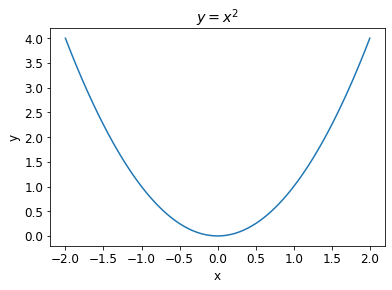

In [21]:
def f(x): return x**2
plot_function(f, 'x', 'y', min=-2, max=2, title='$y=x^{2}$')

Consider the function $f(x)=x^{2}$. We know the minima occurs at $x=0$, but we can also use it to demonstrate Newton's method.

Suppose we start with $x=1$. This cannot be the minima because $f(x)$ is increasing at $x$, that is $f'(x) >0$. Clearly we need to try a smaller $x$.

Equally if we start with $x=-1$, the function is decreasing so we should try a larger $x$. 

We could try always moving some fixed step $d$ in the direction indicated by the derivative, however this may very easily end with us oscillating about the minima. E.g. if $d=0.15$, we will bounce between $0.1$ and $-0.05$.

In order for their to be a minima at $x$ we must have $f'(x)=0$. So as we approach the minima the value of $f'(x)$ should decrease, at least for sufficiently smooth $f$. Therefore it makes more sense to always take a step $-d\times f'(x)$ from $x$. If $d$ is too large, we may still oscillate about the minima, or even move away from it entirely. E.g. in the above example a value of $d=1$ would see us going from $1$ to $-1$ and back. It's still an improvement on a constant step however.

The value of $d$ is called the learning rate. When we do this for multivariate functions we need to replace $f'(x)$ with the gradient of $f$, as such its normally called gradient descent.

Truthfully in Newton's method we would normally move by $-f'(x)/f''(x)$ but computing second order derivatives can be time consuming and is not so easily parrallelised. Hence the use of learning rates instead.

**Loss functions**

Suppose we decided to use an affine function to predict our classes for the handwritten numbers. Our ultimate aim is to produce a model with high accuracy. However accuracy is not a suitable loss function to optimise against. Given a paramters $w_{i,j}, b_{j}$ we of course have a function $acc(w_{i,j}, b_{j})$ which returns the accuracy on the test set for these choices, however it is not everywhere differentiable, or even continuous. Moreover when it is differentiable the derivative is always $0$.

Suppose for simplicity we only have two classes, say we focus on $1$ and $3$. Rather than trying to predict a class, either $1$ or $3$, we can output a float value between $0$ and $1$. Then to get our final predictions we just apply a rounding function.

Given a written digit $d$ then, we might have the actual value $A(d)=1$, if $d$ is a $1$ and $f(d)=t$ say. Then the error here is $abs(1-t)$. We might perhaps take $(1-t)^{2}$ instead and work with squared error.



Of course our original setup of an affine function does not return a number between $0$ and $1$, in fact as currently written it returns a vector. So we need to make some alterations. The general setup is take a second function $g\colon \mathbb{R} \to [0,1]$ and post-compose with it.

A classic choice is the sigmoid function $g(x)=\frac{1}{1+e^{-x}}$.

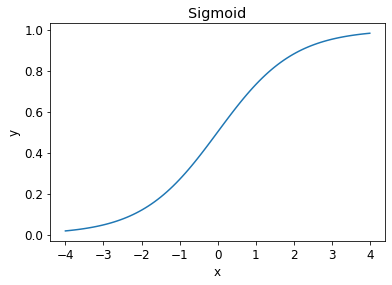

In [22]:
def sigmoid(x): return 1/(1+torch.exp(-x))
plot_function(sigmoid, 'x', 'y', title='Sigmoid', min=-4, max=4)

Our loss function is then $$\sum_{d \in S} A(d)(1-gf(d))+(1-A(d))gf(d).$$

We don't need to take absolute values here since we know that $gf(d)$ is always between $0$ and $1$.

Even for this simple setup the function is very complicated, we would struggle to do the differentiation by hand, fortunately pytorch has functionality to do the calculus for us very quickly.

That being said, it could still potentially take a long time to do the minimise against this function since it involves every single example in our sample. In practice we run work with *batches* of items.

We calculate the average loss for a small group, a batch, of items at a time and use this to inform our next set of paramaters using gradient descent.

In [23]:
weights=mean1-mean3
weights=weights.reshape(28*28)

m1=mean1.reshape(28*28,1)
m3=mean3.reshape(28*28,1)

bias=-weights@m3
d=(weights@m1+bias)

weights=(weights/d).requires_grad_()
bias=(bias/d).requires_grad_()
def f(x): return (weights@x + bias)

In [24]:
def display_weight(weights, ax=None):
    df= pd.DataFrame((weights.view(28,28)))
    sns.heatmap(df, annot=False, ax=ax,  xticklabels=False, yticklabels=False)

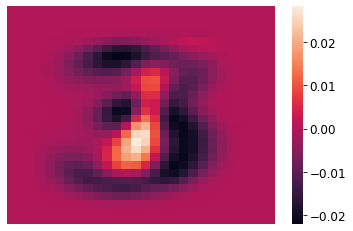

In [25]:
display_weight(weights)

In [26]:
train_x = torch.cat([ones, threes]).view(-1,28*28,1)
train_y = tensor([1]*len(ones) + [0]*len(threes)).unsqueeze(1)
train = list(zip(train_x,train_y))

In [27]:
preds=sigmoid(f(train_x))

def ME(predictions,labels): return (labels*(1-predictions)+(1-labels)*predictions).mean()

In [28]:
ME(preds,train_y)

tensor(0.3794, grad_fn=<MeanBackward0>)

In [29]:
corrects = (preds>0.5).float() == train_y
corrects.float().mean()

tensor(0.7657)

Our starting point, unsurprisingly isn't great. So we're going to need to run our optimisation method.

First we need to create a dataloader object so that we can work with batches rather than the full data.

In [30]:
dl = DataLoader(train, batch_size=256)
x,y = first(dl)

Pytorch will handle the calculus for us, but we need to set up a function to instruct it to do so. We call .backwards() to calculate the derivatives. This just tells pytorch it should use the chain rule to calculate the derivatives.

In [31]:
def calc_grad(x, y,model, loss):
    preds = model(x)
    loss = loss(preds, y)
    loss.backward()

def model(x):
    return sigmoid(f(x))

In [32]:
calc_grad(x, y, model, ME)
weights.grad.mean(),bias.grad

(tensor(-0.0153), tensor([-0.1946]))

Putting it all together we have the following.

In [33]:
def train_epoch(dl, model, loss, lr, params):
    for p in params:
            try: p.grad.zero_()
            except: pass
    for x,y in dl:
        calc_grad(x, y,model, loss)
        for p in params:
            p.data -= p.grad*lr
            #print(abs(p.grad*lr).sum())
            p.grad.zero_()

We need the .grad.zero_() at the end to wipe reset the calculated grad for each paramter as by default pytorch actually returns the new grad + the old grad when you use p.grad. We also do it at the beginning of the function just to make sure we haven't got any grad lingering from a previous calculation.

We also need to be able to quickly calculate the loss and accuracy, then we'll be ready to go.

In [34]:
def acc(model):
    def func(x,y):
        preds=model(x)
        corrects = (preds>0.5).float() == y
        return corrects.float().mean()
    return func

def mean_loss(model, loss):
    def func(x,y):
        preds = model(x)
        return loss(preds, y).mean()
    return func
def mean_batch_calc(func,dl):
    return round(torch.stack([func(x, y) for x,y in dl]).mean().item(),4)

After epoch 1 the loss is 0.3107 and the accuracy is 0.6821
After epoch 2 the loss is 0.1572 and the accuracy is 0.8899
After epoch 3 the loss is 0.0838 and the accuracy is 0.948
After epoch 4 the loss is 0.0559 and the accuracy is 0.9677
After epoch 5 the loss is 0.0419 and the accuracy is 0.9763


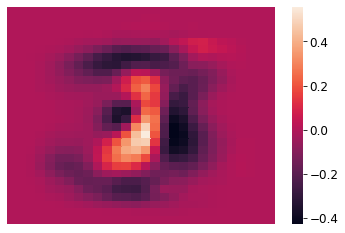

In [35]:
epochs=5
for i in range(0,epochs):
    lr = 1.
    params = weights,bias
    train_epoch(dl, model, ME, lr, params)

    print(f'After epoch {i+1} the loss is {mean_batch_calc(mean_loss(model,ME),dl)} and the accuracy is {mean_batch_calc(acc(model),dl)}')    
display_weight(weights)

The weights actually keep a very similar shape to the those we started with. This isn't just because we started with a good choice. Many of the pixels are not actually that important, so remain unchanged. Plus this kind of method can get stuck at local minima. In particular the output can look quite different when different starting positions are chosen. 

If we choose a similar starting point we would expect roughly the same outcome, but for those which are very different we might get a corresponding difference in output.

In [36]:
def prep(weights):
    bias=-weights@m3
    d=(weights@m1+bias)

    weights=(weights/d).requires_grad_()
    bias=(bias/d).requires_grad_()
    
    return weights,bias

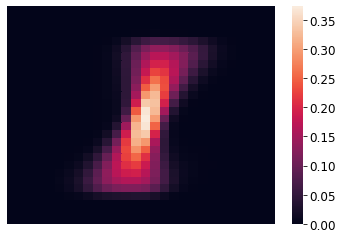

In [37]:
weights2,bias2=prep(mean1.reshape(28*28))
def model2(x): return sigmoid(weights2@x + bias2)

display_weight(weights2)

After epoch 5 the loss is 0.0317 and the accuracy is 0.9777
The mean square difference between the new and old weights is 0.009578711353242397


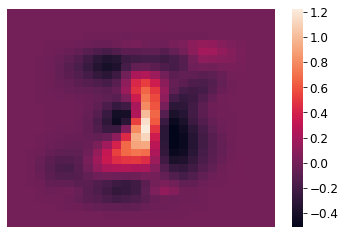

In [38]:
for i in range(0,epochs):
    lr = 1.
    params = weights2,bias2
    train_epoch(dl, model2, ME, lr, params)

print(f'After epoch {i+1} the loss is {mean_batch_calc(mean_loss(model2,ME),dl)} and the accuracy is {mean_batch_calc(acc(model2),dl)}')
print(f'The mean square difference between the new and old weights is {(weights-weights2).square().mean().item()}')
display_weight(weights2)

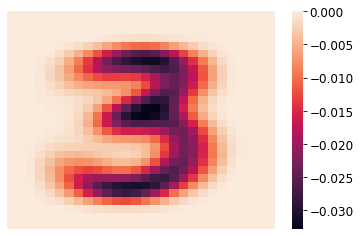

In [39]:
weights2,bias2=prep(-mean3.reshape(28*28))
display_weight(weights2)

After epoch 5 the loss is 0.0442 and the accuracy is 0.9749
The mean square difference between the new and old weights is 8.014351624296978e-05


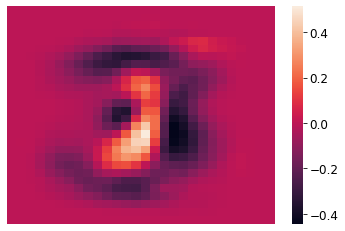

In [40]:
for i in range(0,epochs):
    lr = 1.
    params = weights2,bias2
    train_epoch(dl, model2, ME, lr, params)

print(f'After epoch {i+1} the loss is {mean_batch_calc(mean_loss(model2,ME),dl)} and the accuracy is {mean_batch_calc(acc(model2),dl)}')
print(f'The mean square difference between the new and old weights is {(weights-weights2).square().mean().item()}')
display_weight(weights2)

From both these starting points we get very similar outputs. In fact the final option is nearly indistinguishable from the first. On the other hand we could start with a totally random set of weights and bias, this yields a very different but still reasonably effective set of weights.

In [41]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

weights2 = init_params((28*28))
bias2=init_params(1)

After epoch 5 the loss is 0.0347 and the accuracy is 0.9715
The mean square difference between the new and old weights is 0.9655652046203613


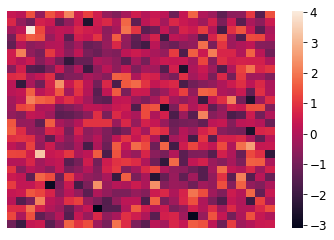

In [42]:
for i in range(0,epochs):
    lr = 1.
    params = weights2,bias2
    train_epoch(dl, model2, ME, lr, params)

print(f'After epoch {i+1} the loss is {mean_batch_calc(mean_loss(model2,ME),dl)} and the accuracy is {mean_batch_calc(acc(model2),dl)}')
print(f'The mean square difference between the new and old weights is {(weights-weights2).square().mean().item()}')
display_weight(weights2)

If we prep the weights to predict $1$ on the mean1 image and $0$ on the mean3 image we get typically get something that looks a bit more like what we had before, but still quite different. It also depends quite a lot on the starting point. Some choices still diverge wildly from our earlier weights.

In [43]:
weights3 = init_params((28*28)).detach()
weights3,bias3=prep(weights3)
def model3(x): return sigmoid(weights3@x + bias3)

After epoch 5 the loss is 0.0363 and the accuracy is 0.9795
The mean square difference between the new and old weights is 0.03166579827666283


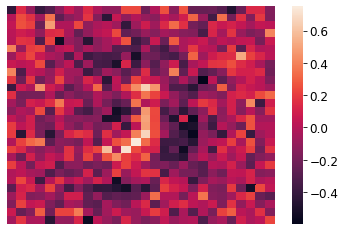

In [44]:
for i in range(0,epochs):
    lr = 1.
    params = weights3,bias3
    train_epoch(dl, model3, ME, lr, params)

print(f'After epoch {i+1} the loss is {mean_batch_calc(mean_loss(model3,ME),dl)} and the accuracy is {mean_batch_calc(acc(model3),dl)}')
print(f'The mean square difference between the new and old weights is {(weights-weights3).square().mean().item()}')
display_weight(weights3)

We can of course combine weights obtained from different starting points, since the problem is largely a linear one. Even without any further training, combining the our first set of learned weights with those coming from a random starting point improves on the accuracy of both.

In [45]:
weights3=((weights+weights2)/2)
bias3=((bias+bias2)/2)

After averaging the loss is 0.0329 and the accuracy is 0.9776


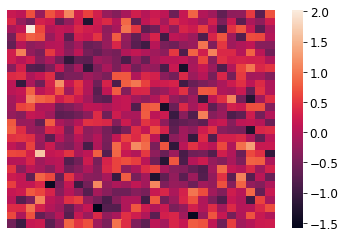

In [46]:
print(f'After averaging the loss is {mean_batch_calc(mean_loss(model3,ME),dl)} and the accuracy is {mean_batch_calc(acc(model3),dl)}')
display_weight(weights3)

In [47]:
test_x = torch.cat([test_ones, test_threes]).view(-1,28*28,1)
test_y = tensor([1]*len(test_ones) + [0]*len(test_threes)).unsqueeze(1)
test = list(zip(test_x,test_y))
test_dl = DataLoader(test, batch_size=256)

In [48]:
print(f'''For the first set of weights on the test set the loss is {mean_batch_calc(mean_loss(model,ME),
        test_dl)} and the accuracy is {mean_batch_calc(acc(model),test_dl)}''')
print(f'''For the weights coming from a random starting matrix on the test set the loss is {mean_batch_calc(mean_loss(model2,ME),
        test_dl)} and the accuracy is {mean_batch_calc(acc(model2),test_dl)}''')
print(f'''For the combined weights on the test set the loss is {mean_batch_calc(mean_loss(model3,ME),
        test_dl)} and the accuracy is {mean_batch_calc(acc(model3),test_dl)}''')

For the first set of weights on the test set the loss is 0.0385 and the accuracy is 0.9779
For the weights coming from a random starting matrix on the test set the loss is 0.0339 and the accuracy is 0.9698
For the combined weights on the test set the loss is 0.03 and the accuracy is 0.9785


It's also interesting that the loss is lower on the random starting matrix. Further the accuracy of the first set of weights is greater on the test than the training set, whereas the random starts performs worse on the test than the training. This probably suggests the latter is a bit overfit.

## Multi-class problems

We simplified the original problem of separating handrwritten versions of $1,3,5$ to a binary classification problem. If we want to extend our solution to work with the more complex version of the problem, we need to make some changes. 

The model for our binary classifier was a linear map $\mathbb{R}^{m} \to \mathbb{R}$ plus a bias, followed by a non-linear function $\mathbb{R} \to [0,1]$ to turn this to an expected class.

If we have $n+1$ classes then the final output is going to need to be a vector of dimension at least $n$. Since we're interpreting the output as a probability of sorts, the sum of the componts should equal $1$, and it should be inside the box $[0,1]^{n}$.

For clarity we are going to output a vector of of dimension $n+1$, with one component corresponding to each class. Than than having an affine function $\mathbb{R}^{m}$ \to $\mathbb{R}$, we then seek one of the form $\mathbb{R}^{m} \to \mathbb{R}^{m}$.
Where before we thought of the affine part of being a matrix of weights plus a bias, we now think of it as being a vector of weight matrices plus a vector of biases. Depending on your background you may think of a vector of matrices as being itself a matrix, or as being a tensor. *For fun, the fact that these descriptions are both simultaneously valid is essentially due to the tensor-hom adjunction (https://en.wikipedia.org/wiki/Tensor-hom_adjunction)*.


Instead of the sigmoid function $$x \to \frac{e^{x}}{e^{x}+1}$$ we now take apply the transformation $$(x_{1},...,x_{n+1}) \to \frac{1}{\sum e^{x_{i}}}(e^{x_{1}},..., e^{x_{n+1}}).$$

This is called the softmax function. We can intepret the binary classification case as having an identical setup except we fix the paramaters of one model to be $0$.

For the loss we can then take the mean square error from the correctly labelled vector.

In [49]:
m5=mean5.reshape(28*28,1)
weights= torch.cat([mean1,mean3,mean5]).reshape(3,28*28).T.requires_grad_()
bias=tensor([0]*3).float().requires_grad_()

In [50]:
def model(x): return F.softmax(x@weights + bias,-1)

def loss(preds,labels): return ((preds-labels)**2).mean()

def labeller(preds): return preds.round().argmax(dim=-1)

def acc(model):
    def func(x,y):
        preds= model(x)
        labels = labeller(preds)
        return (labeller(preds)==y.argmax(dim=-1)).float().mean()
    return func

def mean_loss(model, loss):
    def func(x,y):
        preds = model(x)
        return loss(preds, y).mean()
    return func

In [51]:
train_x = torch.cat([ones, threes, fives]).view(-1,28*28)
train_y = tensor([[1,0,0]]*len(ones) + [[0,1,0]]*len(threes)+ [[0,0,1]]*len(fives))
train = list(zip(train_x,train_y))

In [52]:
dl = DataLoader(train, bs=256)
x,y = first(dl)

In [53]:
f'Our starting point has loss {mean_batch_calc(mean_loss(model,loss),dl)} and accuracy {mean_batch_calc(acc(model),dl)}'

'Our starting point has loss 0.1395 and accuracy 0.7508'

In [54]:
for p in (bias,weights):
            try: p.grad.zero_()
            except: pass

In [55]:
calc_grad(x,y,model,loss)

In [56]:
def calc_grad(x, y,model, loss):
    preds = model(x)
    loss = loss(preds, y)
    loss.backward()

def train_epoch(dl, model, loss, lr, params):
    for p in params:
            try: p.grad.zero_()
            except: pass
    for x,y in dl:
        calc_grad(x, y,model, loss)
        for p in params:
            p.data -= p.grad*lr
            #print(abs(p.grad*lr).sum())
            p.grad.zero_()

This problem is harder than the earlier one so to get the best results we need to be a little creative with the learning rate. We'll have it decay exponentially so that we can tune by increasingly small steps as we move through epochs.

In [57]:
for i in range(0,5):
    lr = np.exp(-i/2)/2
    params = weights,bias
    train_epoch(dl, model, loss, lr, params)
    print(f'After epoch {i+1} we have loss {mean_batch_calc(mean_loss(model,loss),dl)} and accuracy {mean_batch_calc(acc(model),dl)}')

After epoch 1 we have loss 0.1246 and accuracy 0.7667
After epoch 2 we have loss 0.0779 and accuracy 0.8485
After epoch 3 we have loss 0.0544 and accuracy 0.8949
After epoch 4 we have loss 0.0419 and accuracy 0.9189
After epoch 5 we have loss 0.0356 and accuracy 0.9314


In [58]:
test_x = torch.cat([test_ones, test_threes, test_fives]).view(-1,28*28)
test_y = tensor([[1,0,0]]*len(test_ones) + [[0,1,0]]*len(test_threes)+ [[0,0,1]]*len(test_fives))
test = list(zip(test_x,test_y))
test_dl = DataLoader(test, bs=256)

In [59]:
print(f'''On the test set the loss is {mean_batch_calc(mean_loss(model,loss),
        test_dl)} and the accuracy is {mean_batch_calc(acc(model),test_dl)}''')

On the test set the loss is 0.0292 and the accuracy is 0.944


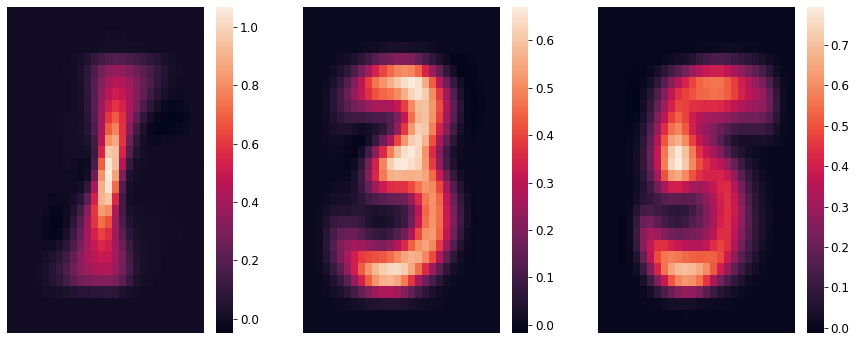

In [60]:
fig, ax =plt.subplots(1,3, figsize=(15,6))

for i,axis in enumerate(ax):
    display_weight(weights[:,i], ax=axis)

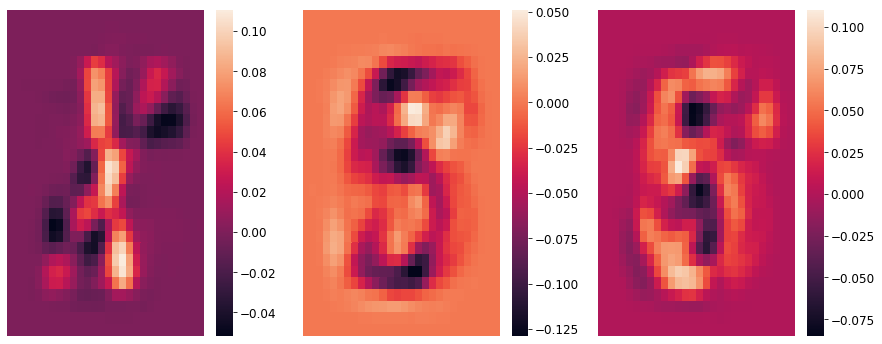

In [61]:
fig, ax =plt.subplots(1,3, figsize=(15,6))

for i,axis in enumerate(ax):
    display_weight(weights[:,i].reshape(28,28)-means[i], ax=axis)

Our new model performs much better than the original, making about half as many errors. Now that we've establed a good setup it's time to tackle the entire dataset.

In [62]:
def pull_label(path):
    return int(str(path)[-1])

def vect_label(k):
    x=[0]*k
    y=[0]*(9-k)
    return tensor(x+[1]+y)

In [63]:
training_paths=(path/'training').ls().sorted()

images=training_paths.map(lambda x: pull_images(x))
labels=L(zip(images.map(len),
             training_paths.map(pull_label).map(vect_label)
            ))

means=images.map(lambda x: x.mean(0))
means=torch.stack(list(means))

train_x = torch.cat(list(images)).view(-1,28*28)
train_y= torch.cat(list(
            labels.map(lambda x: torch.stack([x[1]]*x[0]))
        ))
train = list(zip(train_x,train_y))
dl = DataLoader(train, bs=256)

train_x.shape,train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 10]))

In [64]:
weights=means.clone().reshape(-1,28*28).T
weights=weights.requires_grad_()
bias=tensor([0.]*10).requires_grad_()
def model(x): return F.softmax(x@weights + bias,-1)

In [65]:
f'Our starting point has loss {mean_batch_calc(mean_loss(model,loss),dl)} and accuracy {mean_batch_calc(acc(model),dl)}'

'Our starting point has loss 0.0615 and accuracy 0.6127'

In [66]:
for i in range(0,50):
    lr = max(np.exp(-i/10)/2,0.01)
    params = weights,bias
    train_epoch(dl, model, loss, lr, params)
    if (i+1) % 10 == 0:
        print(f'After epoch {i+1} we have loss {mean_batch_calc(mean_loss(model,loss),dl)} and accuracy {mean_batch_calc(acc(model),dl)}')

After epoch 10 we have loss 0.0206 and accuracy 0.8469
After epoch 20 we have loss 0.0175 and accuracy 0.8683
After epoch 30 we have loss 0.0169 and accuracy 0.873
After epoch 40 we have loss 0.0167 and accuracy 0.8738
After epoch 50 we have loss 0.0167 and accuracy 0.8744


In [67]:
testing_paths=(path/'testing').ls().sorted()

test_images=testing_paths.map(lambda x: pull_images(x))
test_labels=L(zip(test_images.map(len),
             testing_paths.map(pull_label).map(vect_label)
            ))

test_x = torch.cat(list(test_images)).view(-1,28*28)
test_y= torch.cat(list(
            test_labels.map(lambda x: torch.stack([x[1]]*x[0]))
        ))
test = list(zip(test_x,test_y))
test_dl = DataLoader(test, bs=256)

test_x.shape,test_y.shape

(torch.Size([10000, 784]), torch.Size([10000, 10]))

In [68]:
print(f'''On the test set the loss is {mean_batch_calc(mean_loss(model,loss),
        test_dl)} and the accuracy is {mean_batch_calc(acc(model),test_dl)}''')

On the test set the loss is 0.016 and the accuracy is 0.8777


For such a simple model, this isn't a bad score. In fact it's pretty much exactly what LeCun et al. got with a 1-layer NN way back in 1998. You can find a record of the best scores with different techniques [here](http://yann.lecun.com/exdb/mnist/).

Once again we can take a look at some visual representations of the weights we ended up with.

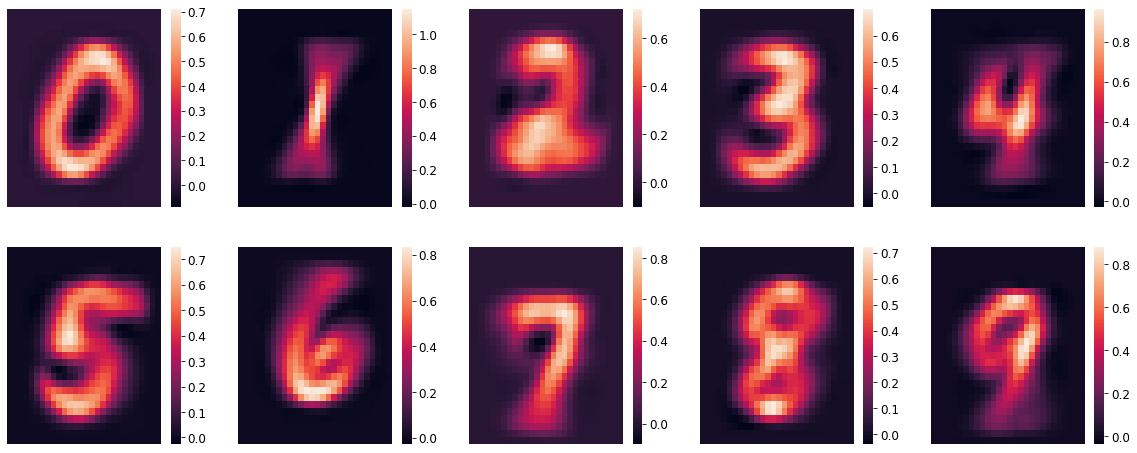

In [69]:
fig, ax =plt.subplots(2,5, figsize=(20,8))

for i,subax in enumerate(ax):
    for j, axis in enumerate(subax):
        display_weight(weights[:,i*5+j], ax=axis)

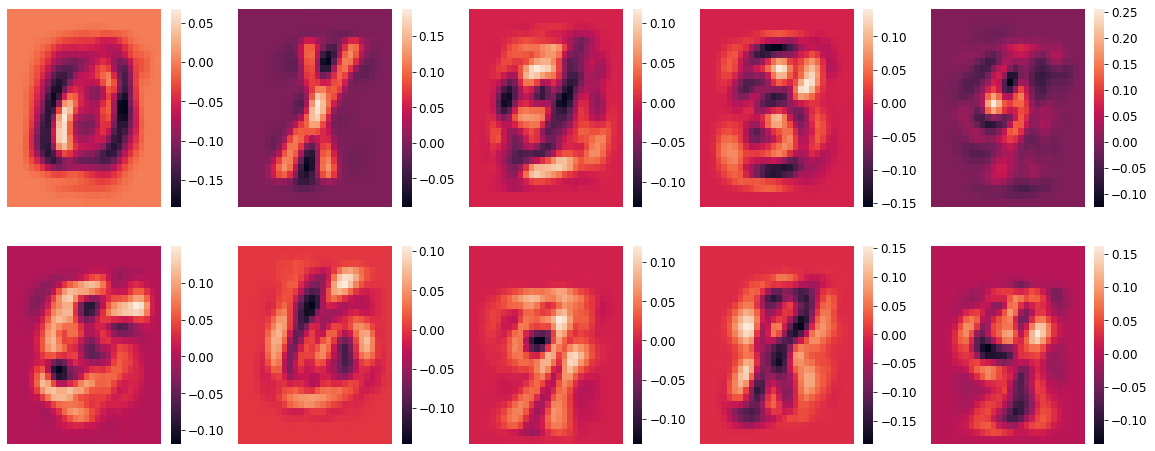

In [70]:
fig, ax =plt.subplots(2,5, figsize=(20,8))

for i,subax in enumerate(ax):
    for j, axis in enumerate(subax):
        display_weight(weights[:,i*5+j].reshape(28,28)-means[i*5+j], ax=axis)

## Improvements

Even for such a simple approach there are host of improvments that can be made. They normally focus on one of two areas.

First is to change either the data or the starting position to make a good minima easier to find. Taking the initial weights to be the mean of each class rather than a random matrix is an example of this. For more complicated models this can be very difficult. In some sense, however, things like transfer learning also work by changing the starting position - we take a solution we know works well for some broad problem and then specialise.

For an example of data modification, we can subtract the global mean from each image. Although this is formally a translation and therefore doesn't impact the value of the loss attained by the global minima, it can help to improve the search. We also saw in the earlier weights that the values outside box in the middle aren't really used. This is because all the digits are centered. Since we're starting from weights that come from the images, this isn't too much of an issue. If we wanted to improve the perfomance of a model coming from a random starting point it could be quite effective to cut out unused pixels.

The second thing that really impacts performance of the model is the learning rate. Ideally we'd like to pick as large a rate as possible but we wan't to avoid overshooting or getting stuck oscillating over a minima. There are various techniques that can help alleviate the issues but quite a nice one is often called the momentum method.

The idea is that rather than updating by $-\epsilon\nabla f(\omega_{i})$ for some learning rate $\epsilon$ we also add a regularising term. In this case we let $D_{i}=\alpha D_{i-1}-\epsilon\nabla f(\omega_{i})$ for some $\alpha \in (0,1)$ and then let $\omega_{i+1}=\omega_{i}+D_{i}$. We start with $D_{0}=0$.

It's called the momentum method because $D_{i}$ can be thought of as a kind of velocity or momentum vector, which keeps pushing it in a direction even if the grad changes.

<AxesSubplot:>

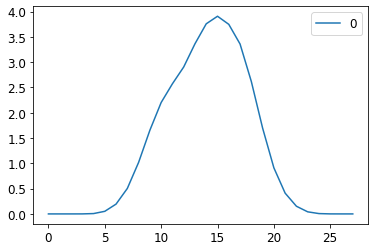

In [71]:
pd.DataFrame((train_x.mean(0).reshape(28,28)**2).sum(0)).plot()

<AxesSubplot:>

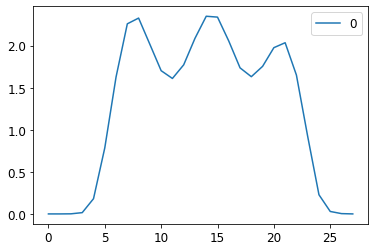

In [72]:
pd.DataFrame((train_x.mean(0).reshape(28,28)**2).sum(-1)).plot()

In [73]:
train = list(zip((train_x-train_x.mean(0)),train_y))
dl = DataLoader(train, bs=256)

test = list(zip(test_x-train_x.mean(0),test_y))
test_dl = DataLoader(test, bs=256)

In [74]:
def train_epoch2(dl, model, loss, lr, params, alpha, deltas):
    for p in params:
            try: p.grad.zero_()
            except: pass
    for x,y in dl:
        calc_grad(x, y,model, loss)
        i=0
        for p in params:
            deltas[i]=alpha*deltas[i]-p.grad*lr
            p.data += deltas[i]
            #print(delta.shape, ndelta.shape)
            #deltas=(deltas[1],ndelta.clone().detach())
            #print(abs(ndelta).sum())
            i+=1
            p.grad.zero_()
    return deltas

In [75]:
weights=means.clone().reshape(-1,28*28).T
weights=weights.requires_grad_()
bias=tensor([0.]*10).requires_grad_()

delta={0:tensor(0),1:tensor(0)}
alpha=0.833


for i in range(0,50):
    lr = 20/(i+5)
    params = weights,bias
    delta= train_epoch2(dl, model, loss, lr, params, alpha,delta)
    if (i+1) % 10 ==0:
        print(f'After epoch {i+1} we have loss {mean_batch_calc(mean_loss(model,loss),dl)} and accuracy {mean_batch_calc(acc(model),dl)}')

After epoch 10 we have loss 0.0162 and accuracy 0.9012
After epoch 20 we have loss 0.0133 and accuracy 0.9163
After epoch 30 we have loss 0.0122 and accuracy 0.9221
After epoch 40 we have loss 0.0116 and accuracy 0.926
After epoch 50 we have loss 0.0113 and accuracy 0.9286


In [76]:
print(f'''On the test set the loss is {mean_batch_calc(mean_loss(model,loss),
        test_dl)} and the accuracy is {mean_batch_calc(acc(model),test_dl)}''')

On the test set the loss is 0.0121 and the accuracy is 0.922


With just these small changes we get a huge improvement in the accuracy, jumping up by 5%. As before we can visualise the weights and see that this time they are much more flexible.

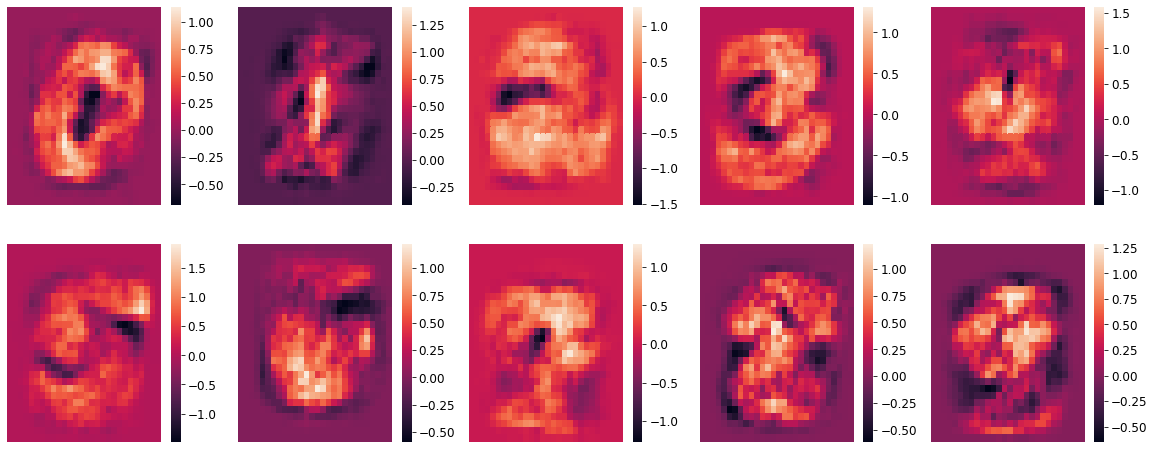

In [77]:
fig, ax =plt.subplots(2,5, figsize=(20,8))

for i,subax in enumerate(ax):
    for j, axis in enumerate(subax):
        display_weight(weights[:,i*5+j], ax=axis)